# Custom Dataset - Flowers with Transfer Learning



<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/flower.png" width="1000" align="center">


In [ ]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/flowers.zip

--2021-03-14 17:36:56--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/flowers.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.46
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235742212 (225M) [application/octet-stream]
Saving to: ‘flowers.zip’

flowers.zip         100%[===================>] 224.82M  37.3MB/s    in 6.5s    

2021-03-14 17:37:03 (34.8 MB/s) - ‘flowers.zip’ saved [235742212/235742212]



In [ ]:
!pip install split_folders

In [ ]:
!unzip flowers.zip

Archive:  flowers.zip
   creating: flowers/
   creating: flowers/daisy/
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/da

### Resnet
https://keras.io/api/applications/resnet/

input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format)


In [ ]:
import splitfolders

In [ ]:
input_folder = 'flowers/'
output_folder = 'processed_data/'

In [ ]:
splitfolders.ratio(input_folder,output_folder,seed=667,ratio=(.6,.2,.2))

Copying files: 4326 files [00:00, 4753.63 files/s]


## Transfer Learning

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/transfer.png" width="600" align="center">

### ResNet50 has input 224x224

In [ ]:
img_height, img_width = (224,224)
batch_size = 16

train_data_dir = 'processed_data/train'
validation_data_dir = 'processed_data/val'
test_data_dir = 'processed_data/test'


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.4
                                    )

In [ ]:

train_generator = train_datagen.flow_from_directory(
                train_data_dir,
                target_size = (img_height,img_width),
                batch_size = batch_size,
                class_mode = 'categorical',
                subset='training') # set a training data

valid_generator = train_datagen.flow_from_directory(
                validation_data_dir,
                target_size = (img_height,img_width),
                batch_size = batch_size,
                class_mode = 'categorical',
                subset='validation') # set a validation data

test_generator = train_datagen.flow_from_directory(
                test_data_dir,
                target_size = (img_height,img_width),
                batch_size = 1,
                class_mode = 'categorical',
                subset='validation') # set a test data

Found 1557 images belonging to 5 classes.
Found 343 images belonging to 5 classes.
Found 347 images belonging to 5 classes.


In [ ]:
X,y = test_generator.next()
X.shape

(1, 224, 224, 3)

In [ ]:
base_model = ResNet50(include_top=False,weights='imagenet')

X = base_model.output
X = GlobalAveragePooling2D()(X)
X = Dense(1024, activation='relu')(X)
predictions = Dense(train_generator.num_classes, activation='softmax')(X)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics = ['accuracy'])

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(train_generator, 
                    epochs=10,
                    shuffle = True,
                    validation_data=valid_generator,
                    #validation_steps=2,
                    )

Epoch 1/10
98/98 [==============================] - 61s 271ms/step - loss: 0.9928 - accuracy: 0.6305 - val_loss: 0.4745 - val_accuracy: 0.8338
Epoch 2/10
98/98 [==============================] - 25s 251ms/step - loss: 0.3110 - accuracy: 0.8977 - val_loss: 0.3914 - val_accuracy: 0.8367
Epoch 3/10
98/98 [==============================] - 25s 252ms/step - loss: 0.1869 - accuracy: 0.9405 - val_loss: 0.3997 - val_accuracy: 0.8251
Epoch 4/10
98/98 [==============================] - 25s 253ms/step - loss: 0.1614 - accuracy: 0.9599 - val_loss: 0.3529 - val_accuracy: 0.8834
Epoch 5/10
98/98 [==============================] - 25s 251ms/step - loss: 0.1063 - accuracy: 0.9747 - val_loss: 0.3977 - val_accuracy: 0.8513
Epoch 6/10
98/98 [==============================] - 25s 251ms/step - loss: 0.0943 - accuracy: 0.9794 - val_loss: 0.4073 - val_accuracy: 0.8805
Epoch 7/10
98/98 [==============================] - 25s 253ms/step - loss: 0.0841 - accuracy: 0.9782 - val_loss: 0.3784 - val_accuracy: 0.8805

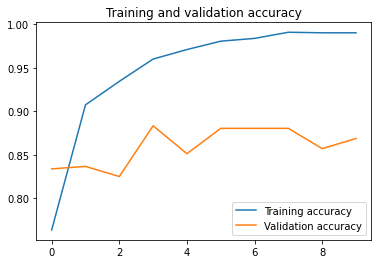

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

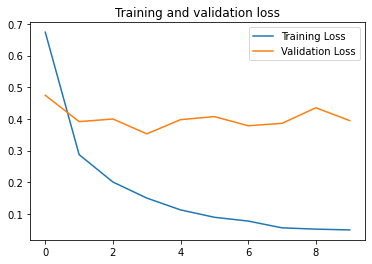

In [ ]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
model.save('ResNet50_flowers.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy ', test_acc)

347/347 - 6s - loss: 0.4649 - accuracy: 0.8559

Test accuracy  0.8559077978134155


In [ ]:
import pandas as pd
import seaborn as sns

model = load_model('ResNet50_flowers.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)

y_prob =[]
y_act = []
test_generator.reset()

for _ in range (nb_samples):
    X_test,y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(y_test)

predicted_class = [list(test_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(test_generator.class_indices.keys())[i.argmax()] for i in y_act]

test_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T, 
                        columns=['predicted_class','actual_class'])
test_df

,predicted_class,actual_class
0,rose,rose
1,sunflower,sunflower
2,dandelion,tulip
3,dandelion,dandelion
4,dandelion,dandelion
...,...,...
342,dandelion,dandelion
343,daisy,daisy
344,daisy,sunflower
345,daisy,daisy


In [ ]:
test_df1 = test_df.head(50)
## Prendo un sample delle prime 50 immagini predette sul test set

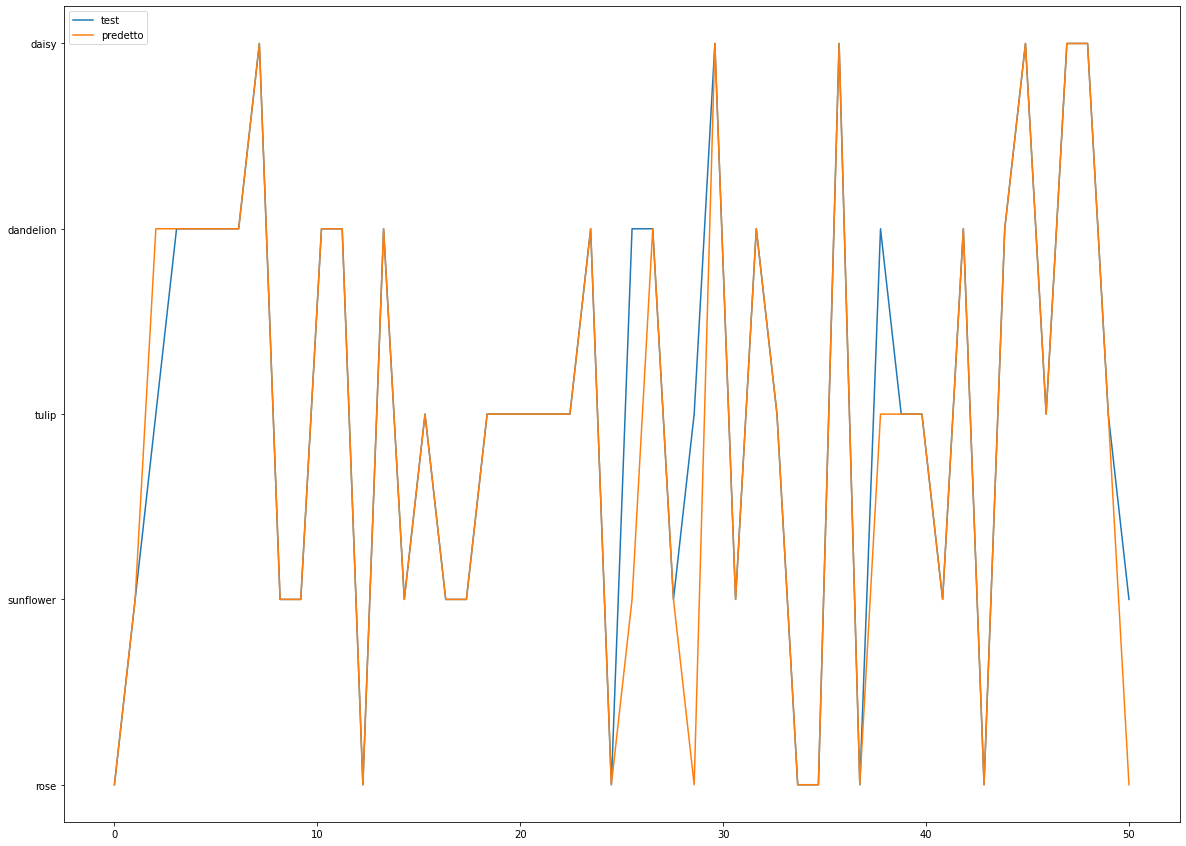

In [ ]:
length = test_df1.shape[0] # 30 
x = np.linspace(0,length,length)


plt.figure(figsize=(20,15))
plt.plot(x, test_df1.actual_class, label='test')
plt.plot(x, test_df1.predicted_class, label='predetto')
plt.legend(loc=2);

### Confusion Matrix

In [ ]:
cm = pd.crosstab(test_df['actual_class'],test_df['predicted_class'],
                 rownames = ['Actual'],
                 colnames = ['Predicted'])

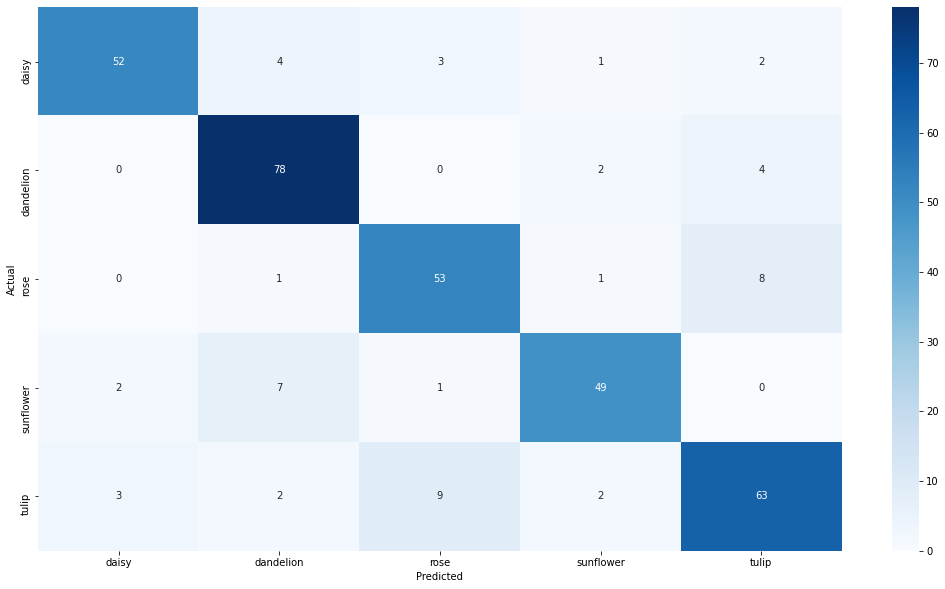

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(cm, cmap='Blues',annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_df['actual_class'],test_df['predicted_class']))

              precision    recall  f1-score   support

       daisy       0.91      0.84      0.87        62
   dandelion       0.85      0.93      0.89        84
        rose       0.80      0.84      0.82        63
   sunflower       0.89      0.83      0.86        59
       tulip       0.82      0.80      0.81        79

    accuracy                           0.85       347
   macro avg       0.85      0.85      0.85       347
weighted avg       0.85      0.85      0.85       347



In [ ]:
# Download test images

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/test_images.zip
!unzip test_images.zip

--2021-03-14 17:42:27--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/test_images.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.149.82
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.149.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280728 (274K) [application/octet-stream]
Saving to: ‘test_images.zip’

test_images.zip     100%[===================>] 274.15K   888KB/s    in 0.3s    

2021-03-14 17:42:28 (888 KB/s) - ‘test_images.zip’ saved [280728/280728]

Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/daisy.jpg   
  inflating: test_images/dandelion.jpg  
  inflating: test_images/rose.jpg    
  inflating: test_images/sunflower.jpg  
  inflating: test_images/tulip.jpg   


In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for fn in uploaded.keys():
#     # predicting images
#     path = '/content/' + fn
#     img = image.load_img(path, target_size=(224, 224))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)

#     images = np.vstack([x])
#     pred = model.predict(images, batch_size=10)
#     print(pred)
#     finale = np.argmax(pred, axis=-1)
#     print(finale)

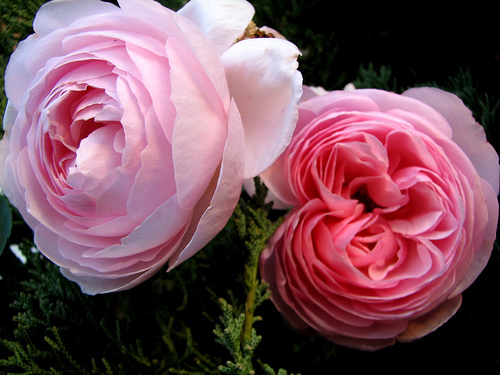

test_images/rose.jpg


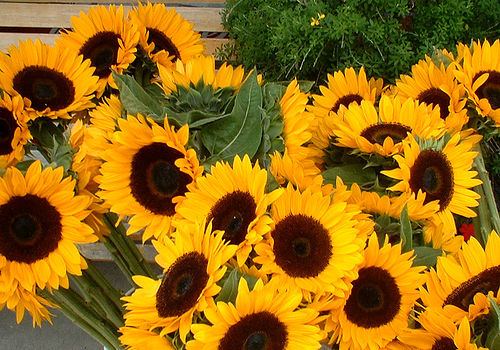

test_images/sunflower.jpg


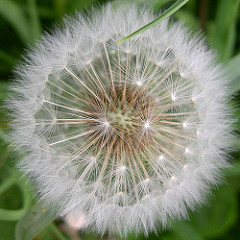

test_images/dandelion.jpg


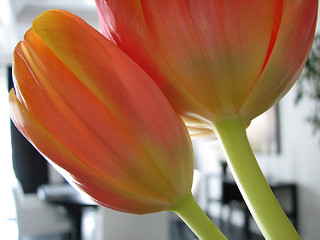

test_images/tulip.jpg


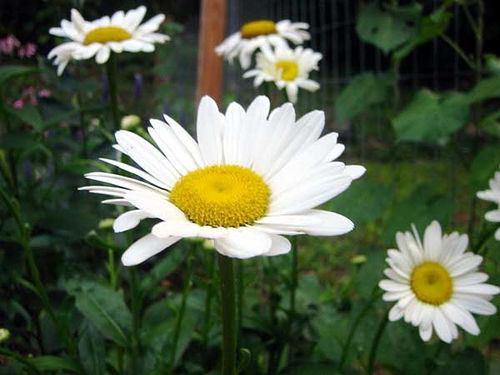

test_images/daisy.jpg


In [ ]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('test_images/*.jpg'): #estensione file
    display(Image(filename=imageName))
    print(imageName)

### Class names

In [ ]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
import os
lista = os.listdir('test_images/') #['rose.jpg', 'sunflower.jpg', 'dandelion.jpg', 'tulip.jpg', 'daisy.jpg']

## train_generator.class_indices
# {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
classes = {0:"daisy",
           1:"dandelion",
           2:"rose",
           3:"sunflower",
           4:"tulip",          
           }

finale=[]
name = []
res = []
for i in lista:
    path = '/content/test_images/' + i
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    pred = model.predict(images, batch_size=10)
    print(pred)
    result = np.argmax(pred, axis=-1)[0]
    print(result)
    name.append(i)
    finale.append(result)
    res.append(classes[result])

finale
print(name)
print(res)

[[1.2564245e-05 1.5509224e-05 9.9960822e-01 3.7128662e-09 3.6374229e-04]]
2
[[8.5427195e-01 2.3438238e-02 8.2958452e-02 3.8537677e-02 7.9374498e-04]]
0
[[4.8675076e-07 9.9999928e-01 2.2700682e-08 2.1918663e-07 1.6320154e-08]]
1
[[2.9017986e-04 2.2450185e-05 5.4843326e-07 1.0568107e-07 9.9968672e-01]]
4
[[9.9999905e-01 9.3850667e-07 2.0375659e-09 9.7382158e-10 1.2458907e-09]]
0
['rose.jpg', 'sunflower.jpg', 'dandelion.jpg', 'tulip.jpg', 'daisy.jpg']
['rose', 'daisy', 'dandelion', 'tulip', 'daisy']
